<a href="https://colab.research.google.com/github/suhwankweon/Reinforcement_2023-2/blob/main/%08MountainCar_SARSA_A68030_%EA%B6%8C%EC%88%98%ED%99%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **최종 선택 모델(ver.3+신뢰구간)**

에피소드 100, 스코어 -607.0, epsilon 0.296, 처음~현재 에피소드까지 소요시간 0분 15초
에피소드 200, 스코어 -350.0, epsilon 0.292, 처음~현재 에피소드까지 소요시간 0분 23초
에피소드 300, 스코어 -672.0, epsilon 0.288, 처음~현재 에피소드까지 소요시간 0분 30초
에피소드 400, 스코어 -555.0, epsilon 0.284, 처음~현재 에피소드까지 소요시간 0분 36초
에피소드 500, 스코어 -476.0, epsilon 0.280, 처음~현재 에피소드까지 소요시간 0분 40초
에피소드 600, 스코어 -534.0, epsilon 0.276, 처음~현재 에피소드까지 소요시간 0분 46초
에피소드 700, 스코어 -423.0, epsilon 0.273, 처음~현재 에피소드까지 소요시간 0분 52초
에피소드 800, 스코어 -407.0, epsilon 0.269, 처음~현재 에피소드까지 소요시간 0분 56초
에피소드 900, 스코어 -412.0, epsilon 0.265, 처음~현재 에피소드까지 소요시간 1분 1초
에피소드 1000, 스코어 -343.0, epsilon 0.261, 처음~현재 에피소드까지 소요시간 1분 5초
에피소드 1100, 스코어 -260.0, epsilon 0.257, 처음~현재 에피소드까지 소요시간 1분 8초
에피소드 1200, 스코어 -258.0, epsilon 0.253, 처음~현재 에피소드까지 소요시간 1분 11초
에피소드 1300, 스코어 -382.0, epsilon 0.249, 처음~현재 에피소드까지 소요시간 1분 15초
에피소드 1400, 스코어 -251.0, epsilon 0.245, 처음~현재 에피소드까지 소요시간 1분 18초
에피소드 1500, 스코어 -249.0, epsilon 0.241, 처음~현재 에피소드까지 소요시간 1분 21초
에피소드 1600, 스코어 -241.0, epsilon 0.237, 처음~현재 에피소드까지 소요시간 1분 24초
에피소드

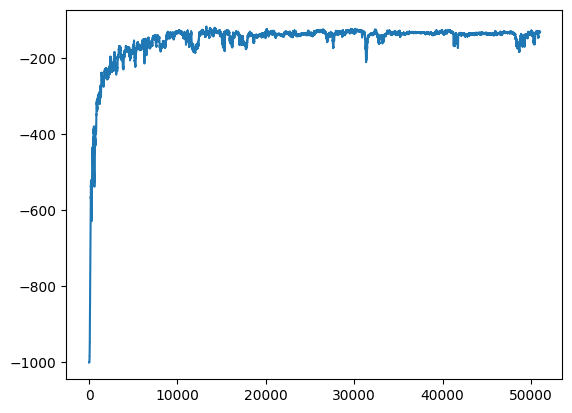

In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import time

# 랜덤 시드를 설정하는 함수 추가
def set_random_seed(seed, env):
    np.random.seed(seed)
    env.seed(seed)

# 이산화 구간 (Position / Velocity)
def get_state(observation):
    pos, vel = observation
    pos_bin = int(np.digitize(pos, pos_space))
    vel_bin = int(np.digitize(vel, vel_space))

    return (pos_bin, vel_bin)

# Q 테이블 업데이트 함수
def update_Q(Q, state, action, reward, state_, action_, alpha, gamma):
    current_Q = Q[state, action]
    next_Q = Q[state_, action_]
    new_Q = current_Q + alpha * (reward + gamma * next_Q - current_Q)
    Q[state, action] = new_Q

# 액션 선택 함수
def select_action(Q, state, epsilon, action_space):
    if np.random.random() < epsilon:
        return np.random.choice(action_space)
    else:
        return max_action(Q, state, action_space)

# 최대값 액션 선택 함수
def max_action(Q, state, actions=[0, 1, 2]):
    values = np.array([Q[state, a] for a in actions])
    action = np.argmax(values)
    return action

# 부트스트랩을 사용하여 평균에 대한 95% 신뢰 구간 계산
def bootstrap_confidence_interval(data, num_samples=1000, alpha=0.05):
    sample_means = []
    n = len(data)

    for _ in range(num_samples):
        # 복원 추출로 샘플을 얻어 평균을 계산
        sample = np.random.choice(data, size=n, replace=True)
        sample_mean = np.mean(sample)
        sample_means.append(sample_mean)

    # 신뢰 구간 계산
    lower_bound = np.percentile(sample_means, (alpha / 2) * 100)
    upper_bound = np.percentile(sample_means, (1 - alpha / 2) * 100)

    return lower_bound, upper_bound

if __name__ == '__main__':
    random_seed = 42

    env = gym.make('MountainCar-v0')
    env._max_episode_steps = 1000
    n_games = 51000
    alpha = 0.1
    gamma = 0.99

    action_space = [0, 1, 2]

    # 이산화 구간 설정(position/velocity)
    pos_space = np.linspace(-1.2, 0.6, 30)
    vel_space = np.linspace(-0.07, 0.07, 30)

    states = [(pos, vel) for pos in range(31) for vel in range(31)]

    # Q 테이블 초기화
    Q = {(state, action): 0 for state in states for action in action_space}

    score = 0
    total_rewards = np.zeros(n_games)
    start_time = time.time()
    max_score = float('-inf')
    max_score_time = 0

    for i in range(n_games):
        # 각 에피소드마다 랜덤시드를 설정.
        set_random_seed(random_seed + i, env)

        done = False
        obs = env.reset()
        state = get_state(obs)
        epsilon = max(0.01, min(0.3, 0.3 - 2/n_games * i))

        if i % 100 == 0 and i > 0:
            current_time = time.time() - start_time
            elapsed_min = int(current_time // 60)
            elapsed_sec = int(current_time % 60)
            print(f'에피소드 {i}, 스코어 {score}, epsilon {epsilon:.3f}, 처음~현재 에피소드까지 소요시간 {elapsed_min}분 {elapsed_sec}초')

        score = 0
        action = select_action(Q, state, epsilon, action_space)

        while not done:
            obs_, reward, done, info = env.step(action)
            state_ = get_state(obs_)
            action_ = select_action(Q, state_, epsilon, action_space)

            # Q 테이블에 해당 조합이 없으면 초기화
            if (state_, action_) not in Q:
                Q[state_, action_] = 0

            update_Q(Q, state, action, reward, state_, action_, alpha, gamma)
            state, action = state_, action_
            score += reward

        total_rewards[i] = score

        if score > max_score:
            max_score = score
            max_score_time = time.time() - start_time

    mean_rewards = np.zeros(n_games)
    for t in range(n_games):
        mean_rewards[t] = np.mean(total_rewards[max(0, t-50):(t+1)])

    # 부트스트랩을 사용하여 95% 신뢰 구간을 계산
    lower_bound, upper_bound = bootstrap_confidence_interval(total_rewards, num_samples=1000, alpha=0.05)
    print(f'평균 스코어 95% 신뢰 구간: ({lower_bound}, {upper_bound})')

    max_score_idx = np.argmax(total_rewards)
    max_score_min = int(max_score_time // 60)
    max_score_sec = int(max_score_time % 60)
    print(f'최고 스코어 에피소드: {max_score_idx}, 스코어: {max_score}, 소요시간: {max_score_min}분 {max_score_sec}초')

    avg_score_total = np.mean(total_rewards[100:50100])
    avg_score_50001_51000 = np.mean(total_rewards[50100:51100])
    print(f'평균 스코어 (Episodes 0 to 50000): {avg_score_total}, 평균 스코어 (Episodes 50001 to 51000): {avg_score_50001_51000}')

    plt.plot(mean_rewards)
    plt.savefig('mountaincar_sarsa.png')


# **[기본 모델] 기본 모델(ver.1)**

episode  100 score  -1000.0 epsilon 0.996
episode  200 score  -1000.0 epsilon 0.992
episode  300 score  -1000.0 epsilon 0.988
episode  400 score  -1000.0 epsilon 0.984
episode  500 score  -1000.0 epsilon 0.980
episode  600 score  -1000.0 epsilon 0.976
episode  700 score  -1000.0 epsilon 0.972
episode  800 score  -1000.0 epsilon 0.968
episode  900 score  -1000.0 epsilon 0.964
episode  1000 score  -1000.0 epsilon 0.960
episode  1100 score  -1000.0 epsilon 0.956
episode  1200 score  -1000.0 epsilon 0.952
episode  1300 score  -1000.0 epsilon 0.948
episode  1400 score  -1000.0 epsilon 0.944
episode  1500 score  -1000.0 epsilon 0.940
episode  1600 score  -1000.0 epsilon 0.936
episode  1700 score  -1000.0 epsilon 0.932
episode  1800 score  -1000.0 epsilon 0.928
episode  1900 score  -1000.0 epsilon 0.924
episode  2000 score  -1000.0 epsilon 0.920
episode  2100 score  -1000.0 epsilon 0.916
episode  2200 score  -1000.0 epsilon 0.912
episode  2300 score  -1000.0 epsilon 0.908
episode  2400 score 

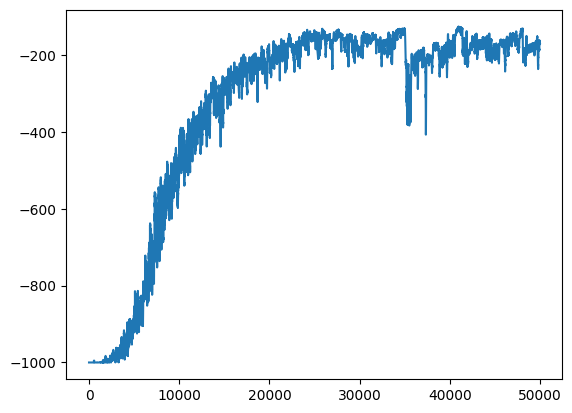

In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from gym import wrappers
import pickle

pos_space = np.linspace(-1.2, 0.6, 12)
vel_space = np.linspace(-0.07, 0.07, 20)

def get_state(observation):
    pos, vel =  observation
    pos_bin = int(np.digitize(pos, pos_space))
    vel_bin = int(np.digitize(vel, vel_space))

    return (pos_bin, vel_bin)

def get_epsilon(i, n_games):
    return max(0.01, min(1, 1.0 - 2/n_games * i))

def update_Q(Q, state, action, reward, state_, action_, alpha, gamma):
    current_Q = Q[state, action]
    next_Q = Q[state_, action_]
    new_Q = current_Q + alpha * (reward + gamma * next_Q - current_Q)
    Q[state, action] = new_Q

def select_action(Q, state, epsilon, action_space):
    if np.random.random() < epsilon:
        return np.random.choice(action_space)
    else:
        return max_action(Q, state, action_space)

def max_action(Q, state, actions=[0, 1, 2]):
    values = np.array([Q[state,a] for a in actions])
    action = np.argmax(values)
    return action

if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    env._max_episode_steps = 1000
    n_games = 50000
    alpha = 0.1
    gamma = 0.99

    action_space = [0, 1, 2]

    states = []
    for pos in range(21):
        for vel in range(21):
            states.append((pos, vel))

    Q = {}
    for state in states:
        for action in action_space:
            Q[state, action] = 0

    score = 0
    total_rewards = np.zeros(n_games)
    for i in range(n_games):
        done = False
        obs = env.reset()
        state = get_state(obs)
        epsilon = get_epsilon(i, n_games)

        if i % 100 == 0 and i > 0:
            print('episode ', i, 'score ', score, 'epsilon %.3f' % epsilon)
        score = 0
        action = select_action(Q, state, epsilon, action_space)
        while not done:
            obs_, reward, done, info = env.step(action)
            state_ = get_state(obs_)
            action_ = select_action(Q, state_, epsilon, action_space)
            update_Q(Q, state, action, reward, state_, action_, alpha, gamma)
            state, action = state_, action_
            score += reward

        total_rewards[i] = score

    mean_rewards = np.zeros(n_games)
    for t in range(n_games):
        mean_rewards[t] = np.mean(total_rewards[max(0, t-50):(t+1)])
    plt.plot(mean_rewards)
    plt.savefig('mountaincar_sarsa.png')




# **[성능 조정 과정] Observation Space(ver.2)**




에피소드 100, 스코어 -1000.0, epsilon 0.996, 처음~현재 에피소드까지 소요시간 0분 11초
에피소드 200, 스코어 -1000.0, epsilon 0.992, 처음~현재 에피소드까지 소요시간 0분 23초
에피소드 300, 스코어 -1000.0, epsilon 0.988, 처음~현재 에피소드까지 소요시간 0분 35초
에피소드 400, 스코어 -1000.0, epsilon 0.984, 처음~현재 에피소드까지 소요시간 0분 47초
에피소드 500, 스코어 -1000.0, epsilon 0.980, 처음~현재 에피소드까지 소요시간 0분 59초
에피소드 600, 스코어 -1000.0, epsilon 0.976, 처음~현재 에피소드까지 소요시간 1분 11초
에피소드 700, 스코어 -1000.0, epsilon 0.973, 처음~현재 에피소드까지 소요시간 1분 23초
에피소드 800, 스코어 -1000.0, epsilon 0.969, 처음~현재 에피소드까지 소요시간 1분 35초
에피소드 900, 스코어 -1000.0, epsilon 0.965, 처음~현재 에피소드까지 소요시간 1분 47초
에피소드 1000, 스코어 -1000.0, epsilon 0.961, 처음~현재 에피소드까지 소요시간 1분 59초
에피소드 1100, 스코어 -1000.0, epsilon 0.957, 처음~현재 에피소드까지 소요시간 2분 11초
에피소드 1200, 스코어 -1000.0, epsilon 0.953, 처음~현재 에피소드까지 소요시간 2분 22초
에피소드 1300, 스코어 -1000.0, epsilon 0.949, 처음~현재 에피소드까지 소요시간 2분 34초
에피소드 1400, 스코어 -1000.0, epsilon 0.945, 처음~현재 에피소드까지 소요시간 2분 45초
에피소드 1500, 스코어 -947.0, epsilon 0.941, 처음~현재 에피소드까지 소요시간 2분 57초
에피소드 1600, 스코어 -1000.0, epsilon 0.937, 처음~현재 에피소드까

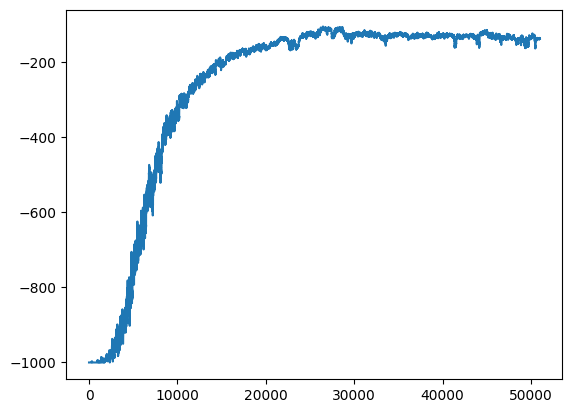

In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import time

pos_space = np.linspace(-1.2, 0.6, 30)
vel_space = np.linspace(-0.07, 0.07, 30)

def get_state(observation):
    pos, vel =  observation
    pos_bin = int(np.digitize(pos, pos_space))
    vel_bin = int(np.digitize(vel, vel_space))

    return (pos_bin, vel_bin)

def get_epsilon(i, n_games):
    return max(0.01, min(1, 1.0 - 2/n_games * i))

def update_Q(Q, state, action, reward, state_, action_, alpha, gamma):
    current_Q = Q[state, action]
    next_Q = Q[state_, action_]
    new_Q = current_Q + alpha * (reward + gamma * next_Q - current_Q)
    Q[state, action] = new_Q

def select_action(Q, state, epsilon, action_space):
    if np.random.random() < epsilon:
        return np.random.choice(action_space)
    else:
        return max_action(Q, state, action_space)

def max_action(Q, state, actions=[0, 1, 2]):
    values = np.array([Q[state,a] for a in actions])
    action = np.argmax(values)
    return action

if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    env._max_episode_steps = 1000
    n_games = 51000
    alpha = 0.1
    gamma = 0.99

    action_space = [0, 1, 2]

    states = []
    for pos in range(31):
        for vel in range(31):
            states.append((pos, vel))

    Q = {}
    for state in states:
        for action in action_space:
            Q[state, action] = 0

    score = 0
    total_rewards = np.zeros(n_games)
    start_time = time.time()
    max_score = float('-inf')
    max_score_time = 0
    for i in range(n_games):
        done = False
        obs = env.reset()
        state = get_state(obs)
        epsilon = get_epsilon(i, n_games)

        if i % 100 == 0 and i > 0:
            current_time = time.time() - start_time
            elapsed_min = int(current_time // 60)
            elapsed_sec = int(current_time % 60)
            print(f'에피소드 {i}, 스코어 {score}, epsilon {epsilon:.3f}, 처음~현재 에피소드까지 소요시간 {elapsed_min}분 {elapsed_sec}초')

        score = 0
        action = select_action(Q, state, epsilon, action_space)
        while not done:
            obs_, reward, done, info = env.step(action)
            state_ = get_state(obs_)
            action_ = select_action(Q, state_, epsilon, action_space)
            update_Q(Q, state, action, reward, state_, action_, alpha, gamma)
            state, action = state_, action_
            score += reward

        total_rewards[i] = score

        # 가장 높은 스코어 갱신한 에피소드 시간 업데이트
        if score > max_score:
            max_score = score
            max_score_time = time.time() - start_time

    mean_rewards = np.zeros(n_games)
    for t in range(n_games):
        mean_rewards[t] = np.mean(total_rewards[max(0, t-50):(t+1)])

    max_score_idx = np.argmax(total_rewards)
    max_score_min = int(max_score_time // 60)
    max_score_sec = int(max_score_time % 60)
    print(f'최고 스코어 에피소드: {max_score_idx}, 스코어: {max_score}, 소요시간: {max_score_min}분 {max_score_sec}초')

    avg_score_total = np.mean(total_rewards[100:50100])
    avg_score_50001_51000 = np.mean(total_rewards[50100:51100])
    print(f'평균 스코어 (Episodes 0 to 50000) : {avg_score_total}, 평균 스코어 (Episodes 50001 to 51000): {avg_score_50001_51000}')

    plt.plot(mean_rewards)
    plt.savefig('mountaincar_sarsa.png')



# **[성능 조정 과정] Epsilon decay adjustment(ver.3)**

에피소드 100, 스코어 -871.0, epsilon 0.296, 처음~현재 에피소드까지 소요시간 0분 7초
에피소드 200, 스코어 -642.0, epsilon 0.292, 처음~현재 에피소드까지 소요시간 0분 14초
에피소드 300, 스코어 -437.0, epsilon 0.288, 처음~현재 에피소드까지 소요시간 0분 19초
에피소드 400, 스코어 -311.0, epsilon 0.284, 처음~현재 에피소드까지 소요시간 0분 24초
에피소드 500, 스코어 -418.0, epsilon 0.280, 처음~현재 에피소드까지 소요시간 0분 28초
에피소드 600, 스코어 -202.0, epsilon 0.276, 처음~현재 에피소드까지 소요시간 0분 32초
에피소드 700, 스코어 -319.0, epsilon 0.273, 처음~현재 에피소드까지 소요시간 0분 35초
에피소드 800, 스코어 -337.0, epsilon 0.269, 처음~현재 에피소드까지 소요시간 0분 40초
에피소드 900, 스코어 -269.0, epsilon 0.265, 처음~현재 에피소드까지 소요시간 0분 43초
에피소드 1000, 스코어 -245.0, epsilon 0.261, 처음~현재 에피소드까지 소요시간 0분 46초
에피소드 1100, 스코어 -364.0, epsilon 0.257, 처음~현재 에피소드까지 소요시간 0분 48초
에피소드 1200, 스코어 -332.0, epsilon 0.253, 처음~현재 에피소드까지 소요시간 0분 52초
에피소드 1300, 스코어 -273.0, epsilon 0.249, 처음~현재 에피소드까지 소요시간 0분 56초
에피소드 1400, 스코어 -311.0, epsilon 0.245, 처음~현재 에피소드까지 소요시간 0분 58초
에피소드 1500, 스코어 -298.0, epsilon 0.241, 처음~현재 에피소드까지 소요시간 1분 0초
에피소드 1600, 스코어 -332.0, epsilon 0.237, 처음~현재 에피소드까지 소요시간 1분 3초
에피소드

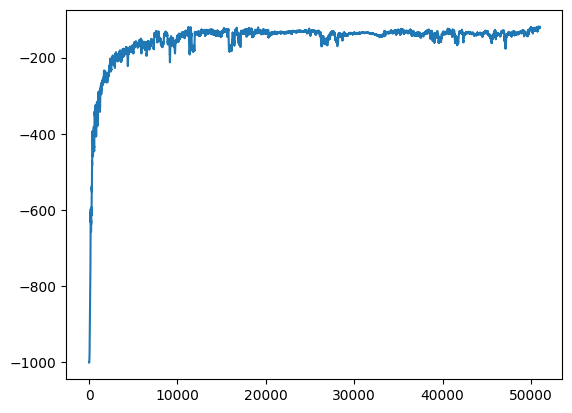

In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import time

pos_space = np.linspace(-1.2, 0.6, 30)
vel_space = np.linspace(-0.07, 0.07, 30)

def get_state(observation):
    pos, vel =  observation
    pos_bin = int(np.digitize(pos, pos_space))
    vel_bin = int(np.digitize(vel, vel_space))

    return (pos_bin, vel_bin)

def get_epsilon(i, n_games):
    return max(0.01, min(0.3, 0.3 - 2/n_games * i))

def update_Q(Q, state, action, reward, state_, action_, alpha, gamma):
    current_Q = Q[state, action]
    next_Q = Q[state_, action_]
    new_Q = current_Q + alpha * (reward + gamma * next_Q - current_Q)
    Q[state, action] = new_Q

def select_action(Q, state, epsilon, action_space):
    if np.random.random() < epsilon:
        return np.random.choice(action_space)
    else:
        return max_action(Q, state, action_space)

def max_action(Q, state, actions=[0, 1, 2]):
    values = np.array([Q[state,a] for a in actions])
    action = np.argmax(values)
    return action

if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    env._max_episode_steps = 1000
    n_games = 51000
    alpha = 0.1
    gamma = 0.99

    action_space = [0, 1, 2]

    states = []
    for pos in range(31):
        for vel in range(31):
            states.append((pos, vel))

    Q = {}
    for state in states:
        for action in action_space:
            Q[state, action] = 0

    score = 0
    total_rewards = np.zeros(n_games)
    start_time = time.time()
    max_score = float('-inf')  # Initialize max_score to negative infinity
    max_score_time = 0
    for i in range(n_games):
        done = False
        obs = env.reset()
        state = get_state(obs)
        epsilon = get_epsilon(i, n_games)

        if i % 100 == 0 and i > 0:
            current_time = time.time() - start_time
            elapsed_min = int(current_time // 60)
            elapsed_sec = int(current_time % 60)
            print(f'에피소드 {i}, 스코어 {score}, epsilon {epsilon:.3f}, 처음~현재 에피소드까지 소요시간 {elapsed_min}분 {elapsed_sec}초')

        score = 0
        action = select_action(Q, state, epsilon, action_space)
        while not done:
            obs_, reward, done, info = env.step(action)
            state_ = get_state(obs_)
            action_ = select_action(Q, state_, epsilon, action_space)
            update_Q(Q, state, action, reward, state_, action_, alpha, gamma)
            state, action = state_, action_
            score += reward

        total_rewards[i] = score

        # 가장 높은 스코어 갱신한 에피소드 시간 업데이트
        if score > max_score:
            max_score = score
            max_score_time = time.time() - start_time

    mean_rewards = np.zeros(n_games)
    for t in range(n_games):
        mean_rewards[t] = np.mean(total_rewards[max(0, t-50):(t+1)])

    max_score_idx = np.argmax(total_rewards)
    max_score_min = int(max_score_time // 60)
    max_score_sec = int(max_score_time % 60)
    print(f'최고 스코어 에피소드: {max_score_idx}, 스코어: {max_score}, 소요시간: {max_score_min}분 {max_score_sec}초')

    avg_score_total = np.mean(total_rewards[100:50100])
    avg_score_50001_51000 = np.mean(total_rewards[50100:51100])
    print(f'평균 스코어 (Episodes 0 to 50000) : {avg_score_total}, 평균 스코어 (Episodes 50001 to 51000): {avg_score_50001_51000}')

    plt.plot(mean_rewards)
    plt.savefig('mountaincar_sarsa.png')



# **[성능 조정 과정] Hyperparameter adjustment(ver.4)**
 - Gamma 0.9

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


에피소드 100, 스코어 -1000.0, epsilon 0.296, 처음~현재 에피소드까지 소요시간 0분 12초
에피소드 200, 스코어 -405.0, epsilon 0.292, 처음~현재 에피소드까지 소요시간 0분 22초
에피소드 300, 스코어 -615.0, epsilon 0.288, 처음~현재 에피소드까지 소요시간 0분 27초
에피소드 400, 스코어 -397.0, epsilon 0.284, 처음~현재 에피소드까지 소요시간 0분 31초
에피소드 500, 스코어 -356.0, epsilon 0.280, 처음~현재 에피소드까지 소요시간 0분 36초
에피소드 600, 스코어 -278.0, epsilon 0.276, 처음~현재 에피소드까지 소요시간 0분 40초
에피소드 700, 스코어 -276.0, epsilon 0.273, 처음~현재 에피소드까지 소요시간 0분 43초
에피소드 800, 스코어 -355.0, epsilon 0.269, 처음~현재 에피소드까지 소요시간 0분 46초
에피소드 900, 스코어 -204.0, epsilon 0.265, 처음~현재 에피소드까지 소요시간 0분 50초
에피소드 1000, 스코어 -275.0, epsilon 0.261, 처음~현재 에피소드까지 소요시간 0분 52초
에피소드 1100, 스코어 -377.0, epsilon 0.257, 처음~현재 에피소드까지 소요시간 0분 55초
에피소드 1200, 스코어 -194.0, epsilon 0.253, 처음~현재 에피소드까지 소요시간 0분 58초
에피소드 1300, 스코어 -245.0, epsilon 0.249, 처음~현재 에피소드까지 소요시간 1분 0초
에피소드 1400, 스코어 -254.0, epsilon 0.245, 처음~현재 에피소드까지 소요시간 1분 4초
에피소드 1500, 스코어 -322.0, epsilon 0.241, 처음~현재 에피소드까지 소요시간 1분 6초
에피소드 1600, 스코어 -197.0, epsilon 0.237, 처음~현재 에피소드까지 소요시간 1분 8초
에피소드

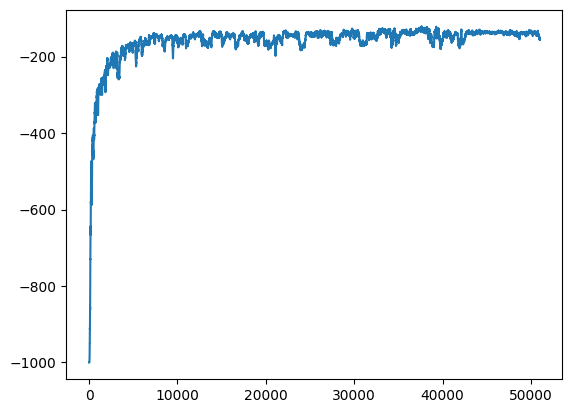

In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import time

pos_space = np.linspace(-1.2, 0.6, 30)
vel_space = np.linspace(-0.07, 0.07, 30)

def get_state(observation):
    pos, vel =  observation
    pos_bin = int(np.digitize(pos, pos_space))
    vel_bin = int(np.digitize(vel, vel_space))

    return (pos_bin, vel_bin)

def get_epsilon(i, n_games):
    return max(0.01, min(0.3, 0.3 - 2/n_games * i))

def update_Q(Q, state, action, reward, state_, action_, alpha, gamma):
    current_Q = Q[state, action]
    next_Q = Q[state_, action_]
    new_Q = current_Q + alpha * (reward + gamma * next_Q - current_Q)
    Q[state, action] = new_Q

def select_action(Q, state, epsilon, action_space):
    if np.random.random() < epsilon:
        return np.random.choice(action_space)
    else:
        return max_action(Q, state, action_space)

def max_action(Q, state, actions=[0, 1, 2]):
    values = np.array([Q[state,a] for a in actions])
    action = np.argmax(values)
    return action

if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    env._max_episode_steps = 1000
    n_games = 51000
    alpha = 0.1
    gamma = 0.9

    action_space = [0, 1, 2]

    states = []
    for pos in range(31):
        for vel in range(31):
            states.append((pos, vel))

    Q = {}
    for state in states:
        for action in action_space:
            Q[state, action] = 0

    score = 0
    total_rewards = np.zeros(n_games)
    start_time = time.time()
    max_score = float('-inf')  # Initialize max_score to negative infinity
    max_score_time = 0
    for i in range(n_games):
        done = False
        obs = env.reset()
        state = get_state(obs)
        epsilon = get_epsilon(i, n_games)

        if i % 100 == 0 and i > 0:
            current_time = time.time() - start_time
            elapsed_min = int(current_time // 60)
            elapsed_sec = int(current_time % 60)
            print(f'에피소드 {i}, 스코어 {score}, epsilon {epsilon:.3f}, 처음~현재 에피소드까지 소요시간 {elapsed_min}분 {elapsed_sec}초')

        score = 0
        action = select_action(Q, state, epsilon, action_space)
        while not done:
            obs_, reward, done, info = env.step(action)
            state_ = get_state(obs_)
            action_ = select_action(Q, state_, epsilon, action_space)
            update_Q(Q, state, action, reward, state_, action_, alpha, gamma)
            state, action = state_, action_
            score += reward

        total_rewards[i] = score

        # 가장 높은 스코어 갱신한 에피소드 시간 업데이트
        if score > max_score:
            max_score = score
            max_score_time = time.time() - start_time

    mean_rewards = np.zeros(n_games)
    for t in range(n_games):
        mean_rewards[t] = np.mean(total_rewards[max(0, t-50):(t+1)])

    max_score_idx = np.argmax(total_rewards)
    max_score_min = int(max_score_time // 60)
    max_score_sec = int(max_score_time % 60)
    print(f'최고 스코어 에피소드: {max_score_idx}, 스코어: {max_score}, 소요시간: {max_score_min}분 {max_score_sec}초')

    avg_score_total = np.mean(total_rewards[100:50100])
    avg_score_50001_51000 = np.mean(total_rewards[50100:51100])
    print(f'평균 스코어 (Episodes 0 to 50000) : {avg_score_total}, 평균 스코어 (Episodes 50001 to 51000): {avg_score_50001_51000}')

    plt.plot(mean_rewards)
    plt.savefig('mountaincar_sarsa.png')

